###Mount Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Installations

In [5]:
#BLIP is now officially integrated into LAVIS - a one-stop library for language-and-vision research and applications!
!pip install salesforce-lavis

In [6]:
!pip install datasets #dataset from Hugging Face

In [7]:
!pip install rouge_score

###Imports

In [8]:
import torch
import os
import shutil
from PIL import Image
from transformers import get_scheduler
from lavis.models import load_model_and_preprocess
from datasets import load_dataset, load_metric

###Device setup

In [9]:
# setup device to use
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

###Model

In [10]:
# loads BLIP-2 pre-trained model
# Use pretrained_{LLM} model types for zero-shot image-to-text generation with prompts.
model, vis_processors, text_processors = load_model_and_preprocess(name="blip2_t5", model_type="pretrain_flant5xl", is_eval=True, device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 1.89G/1.89G [00:07<00:00, 260MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

100%|██████████| 407M/407M [00:01<00:00, 325MB/s]


In [11]:
model.to(device)

Blip2T5(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-38): 39 x Block(
        (norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1408, out_features=4224, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1408, out_features=1408, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1408, out_features=6144, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
 

To test the model

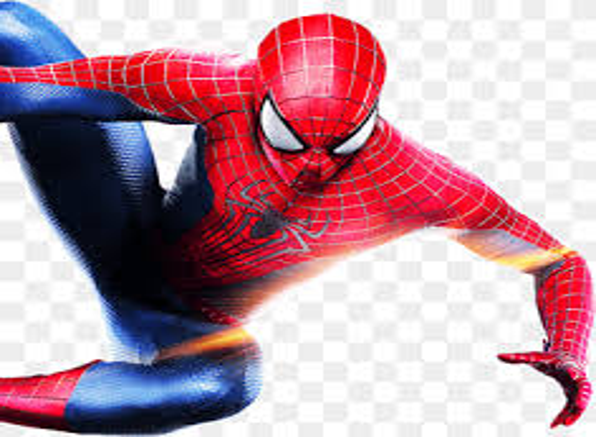

In [12]:
file_path = os.path.join("/content/drive/My Drive", "images.jpeg")
raw_image = Image.open(file_path).convert("RGB")
display(raw_image.resize((596, 437)))

In [13]:
# prepare the image
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
print(image)

tensor([[[[ 1.4924,  1.2880,  0.4851,  ...,  1.6822,  1.6822,  1.6822],
          [-0.7704, -1.0039, -1.2959,  ...,  1.6822,  1.6822,  1.6822],
          [-1.1207, -1.0331, -0.9164,  ...,  1.6822,  1.6822,  1.6822],
          ...,
          [ 1.6238,  1.6676,  1.7260,  ...,  1.9303,  1.9303,  1.9303],
          [ 1.6822,  1.6968,  1.6968,  ...,  1.9303,  1.9303,  1.9303],
          [ 1.7114,  1.7114,  1.6822,  ...,  1.9303,  1.9303,  1.9303]],

         [[ 1.7147,  1.5796,  0.8893,  ...,  1.8198,  1.8198,  1.8198],
          [-0.1163, -0.2663, -0.5065,  ...,  1.8198,  1.8198,  1.8198],
          [-0.2963, -0.1463,  0.0338,  ...,  1.8198,  1.8198,  1.8198],
          ...,
          [ 1.7597,  1.8047,  1.8648,  ...,  2.0749,  2.0749,  2.0749],
          [ 1.8198,  1.8348,  1.8348,  ...,  2.0749,  2.0749,  2.0749],
          [ 1.8498,  1.8498,  1.8198,  ...,  2.0749,  2.0749,  2.0749]],

         [[ 1.8757,  1.8473,  1.3780,  ...,  1.9042,  1.9042,  1.9042],
          [ 1.5202,  1.4633,  

In [14]:
model.generate({"image": image, "prompt": "Question: What can see in the picture? Answer:"})

['a spider - man flying in the air, hd png download']

In [15]:
model.generate({"image": image, "prompt": "Question: which city is this? Answer:"})

['new york city, hd png download']

Model is randomly generating city name although no information about the city is provided in the picture.

###Data Prep

In [16]:
# 60-20-20 split for training, validation and testing
# training_dataset = load_dataset("hongrui/mimic_chest_xray_v_1", split="train[:53640]")
# validation_dataset = load_dataset("hongrui/mimic_chest_xray_v_1", split="train[53640:71520]")
testing_dataset = load_dataset("hongrui/mimic_chest_xray_v_1", split="train[71520:]")
few_shot_dataset = load_dataset("hongrui/mimic_chest_xray_v_1", split="train[60000:60005]")

Generating train split:   0%|          | 0/89395 [00:00<?, ? examples/s]

In [17]:
# Prepare the dataset
def transform(example_batch, few_shot_examples):
    rationale = example_batch["text"]
    images = example_batch["image"]
    # Iterate through the list of lists and concatenate the questions with the separator token
    processed_prompts = []
    texts = []
    few_shot_dataset = prepare_few_shot_dataset(few_shot_examples)
    for i, rationale in enumerate(zip(rationale)):
        # blip_prompt = """Generate report based on rationale where Rational is {} Report: """
        blip_prompt = """Question: What can be reported from the x-ray image? Report: """
        text = few_shot_dataset + blip_prompt
        # text = blip_prompt
        texts.append(text)
    return {"text_inputs": texts}

In [18]:
#for few-shot predictions
def prepare_few_shot_dataset(example):
    prompts = ""
    # print(example)
    rationale = example["text"]
    images = example["image"]
    report = example["report"]
    for i in range(len(example)):
        prompt_text = "Image: {} Question: What can be reported from the x-ray image? Report: {}"
        prompt = prompt_text.format(vis_processors["train"](images[i].convert("RGB")).unsqueeze(0), report[i])
        prompts += " [SEP] " + prompt
    return prompts

In [19]:
from functools import partial
# train_dataset = training_dataset.map(transform, batched=True, remove_columns=["text"])
# eval_dataset = validation_dataset.map(transform, batched=True, remove_columns=["text"])
# Use partial to pass the few_shot_dataset argument
transform_partial = partial(transform, few_shot_examples=few_shot_dataset)
test_dataset = testing_dataset.map(transform_partial, batched=True,)

Map:   0%|          | 0/17875 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/lavis/processors/randaugment.py:40: RuntimeWarning: overflow encountered in scalar negative
  offset = -low * scale


In [20]:
from torch.nn.utils.rnn import pad_sequence
# Custom collate function to handle padding
def collate_fn(batch):
    image = torch.stack([vis_processors["eval"](item["image"].convert("RGB")).to(device) for item in batch])
    input_ids = [item["text_inputs"] for item in batch]
    target_ids = [item["report"] for item in batch]
    return {"pixel_values": image, "input_ids": input_ids, "labels": target_ids}

In [21]:
# DataLoader
from torch.utils.data import DataLoader
# train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True, collate_fn=collate_fn)
# eval_dataloader = DataLoader(eval_dataset, batch_size=50, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=True, collate_fn=collate_fn)

###Evaluation Metrics

In [22]:
from datasets import load_metric
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Load metrics
rouge = load_metric('rouge')
bleu = load_metric('bleu')
meteor = load_metric('meteor')

def compute_metrics(eval_pred):
    # print(f'eval_pred is {eval_pred}')
    predictions, labels = eval_pred
    results = {
        "rouge1": 0, "rouge2": 0, "rougeL": 0, "bleu": 0, "meteor": 0
    }

    if not predictions or not labels:
        print("Empty predictions or labels.")
        return results
    try:
        rouge_result = rouge.compute(predictions=predictions, references=labels)
        results.update({
            "rouge1": rouge_result['rouge1'].mid.fmeasure,
            "rouge2": rouge_result['rouge2'].mid.fmeasure,
            "rougeL": rouge_result['rougeL'].mid.fmeasure
        })
    except Exception as e:
        print(f"Error computing ROUGE: {e}")

    try:
        meteor_result = meteor.compute(predictions=predictions, references=labels)
        results['meteor'] = meteor_result['meteor']
    except Exception as e:
        print(f"Error computing METEOR: {e}")

    return results

<ipython-input-22-17f3f6bb9a19>:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric('rouge')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for meteor contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/meteor/meteor.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


###Fine-tune

In [23]:
# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [40], gamma=0.1)
best_loss = float('inf')
checkpoint_interval = 1  # Save a checkpoint every 1 epochs
num_epochs = 20  # Number of epochs for training

In [20]:
def save_checkpoint(state, is_best, checkpoint_folder='/content/drive/My Drive/VLM/checkpoints/', filename='checkpoint_{}.pth.tar'):
    if not os.path.exists(checkpoint_folder):
        os.makedirs(checkpoint_folder)
    checkpoint_file = os.path.join(checkpoint_folder, filename.format(state['epoch']))
    torch.save(state, checkpoint_file)

    if is_best:
        best_model_file = os.path.join(checkpoint_folder, 'model_best.pth.tar')
        shutil.copyfile(checkpoint_file, best_model_file)

In [28]:
epoch = 16

In [29]:
# Assuming model, optimizer, and train_dataloader are already defined
while(epoch<num_epochs):
    lr = scheduler.get_last_lr()
    print(f"Epoch: {epoch + 1:d}  LR: {lr[0]:.8f}")
    model.train()  # Set the model to training mode
    train_loss = 0
    is_best = False
    for batch in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model({"image": batch['pixel_values'], "text_input": batch['input_ids'], "text_output": batch['labels']})
        # Compute loss
        loss = outputs['loss']
        train_loss += loss.item()
        # Backward pass
        loss.backward()
        # Update model parameters
        optimizer.step()
    train_loss /= len(train_dataloader)  # Calculate average loss for the epoch
    # Evaluate on the validation set
    eval_loss = 0
    model.eval()
    i = 0
    with torch.no_grad():
        for batch in eval_dataloader:
            print(f"Eval batch:",i)
            i += 1
            outputs = model({"image": batch['pixel_values'], "text_input": batch['input_ids'], "text_output": batch['labels']})
            loss = outputs['loss']
            eval_loss += loss.item()
    eval_loss /= len(eval_dataloader)  # Calculate average evaluation loss
    # Save the model if the current epoch's loss is the best we've seen so far
    print("Train loss: {}, Eval loss: {}".format(train_loss, eval_loss))
    if eval_loss < best_loss and eval_loss < train_loss:
        is_best = True
        best_loss = eval_loss

    save_checkpoint({"epoch": epoch+1, "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict()},
                is_best,)
    print(f'Regular checkpoint saved at epoch {epoch + 1}')
    scheduler.step()
    epoch += 1


Epoch: 17  LR: 0.00005000
Eval batch: 0
Eval batch: 1
Eval batch: 2
Eval batch: 3
Eval batch: 4
Eval batch: 5
Eval batch: 6
Eval batch: 7
Eval batch: 8
Eval batch: 9
Eval batch: 10
Eval batch: 11
Eval batch: 12
Eval batch: 13
Eval batch: 14
Eval batch: 15
Eval batch: 16
Eval batch: 17
Eval batch: 18
Eval batch: 19
Eval batch: 20
Eval batch: 21
Eval batch: 22
Eval batch: 23
Eval batch: 24
Eval batch: 25
Eval batch: 26
Eval batch: 27
Eval batch: 28
Eval batch: 29
Eval batch: 30
Eval batch: 31
Eval batch: 32
Eval batch: 33
Eval batch: 34
Eval batch: 35
Eval batch: 36
Eval batch: 37
Eval batch: 38
Eval batch: 39
Eval batch: 40
Eval batch: 41
Eval batch: 42
Eval batch: 43
Eval batch: 44
Eval batch: 45
Eval batch: 46
Eval batch: 47
Eval batch: 48
Eval batch: 49
Eval batch: 50
Eval batch: 51
Eval batch: 52
Eval batch: 53
Eval batch: 54
Eval batch: 55
Eval batch: 56
Eval batch: 57
Eval batch: 58
Eval batch: 59
Eval batch: 60
Eval batch: 61
Eval batch: 62
Eval batch: 63
Eval batch: 64
Eval batc

###Load best model

In [24]:
def load_checkpoint(checkpoint_path, model, optimizer):
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint '{checkpoint_path}'")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        epoch = checkpoint['epoch']
        print(f"Checkpoint loaded. Resuming from epoch {epoch}.")
        return model, optimizer, epoch
    else:
        print(f"No checkpoint found at '{checkpoint_path}'")
        return model, optimizer, None

In [25]:
model, optimizer, epoch = load_checkpoint('/content/drive/My Drive/VLM/checkpoints/model_best.pth.tar', model, optimizer)

Loading checkpoint '/content/drive/My Drive/VLM/checkpoints/model_best.pth.tar'
Checkpoint loaded. Resuming from epoch 9.


###Test

In [28]:
model.eval()  # Set to evaluation mode
# Assume new_data is preprocessed similarly to training data
with torch.no_grad():
    predictions = []
    labels = []
    for batch in test_dataloader:
        # print(batch['input_ids'])
        predictions += model.generate({"image": batch['pixel_values'], 'prompts': batch['input_ids']})
        labels += batch['labels']
        # print(predictions)
        # print(batch['labels'])
        # break
    # Compute metrics
    metrics = compute_metrics((predictions, labels))
    print(metrics)

{'rouge1': 0.25264551410926145, 'rouge2': 0.08892763797332726, 'rougeL': 0.19336796004121515, 'bleu': 0.0, 'meteor': 0.14152288479009167}
